In [1]:
# Add src directory to Python path for module imports
import sys
import os
sys.path.insert(0, os.path.abspath('../src'))

# Depth from Defocus Tutorial

This notebook demonstrates the complete depth-from-defocus pipeline using alternating minimization.

## Overview
The pipeline consists of:
1. **Data Loading**: Load ground truth all-in-focus (AIF) image and depth map
2. **Forward Model**: Generate synthetic defocus stack from ground truth
3. **AIF Initialization**: Compute initial AIF using MRF optimization
4. **Alternating Minimization**: Jointly optimize depth and AIF
5. **Evaluation**: Compute accuracy metrics
6. **Post-processing (optional)**: Remove outliers

---

## Setup

First, import necessary libraries:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Custom modules for depth-from-defocus
from dataset_params import DatasetParams
import dataset_loader
import utils
import forward_model
import initialization
import alternating_minimization
import outlier_removal

/home/holly/Documents/depth-from-defocus/dfd/dfd-sparse/lib/python3.12/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


---

## Step 1: Load Example Data

Load a sample image from the NYUv2 dataset. This includes:
- **Ground truth AIF image**: The all-in-focus RGB image
- **Ground truth depth map**: Per-pixel depth values

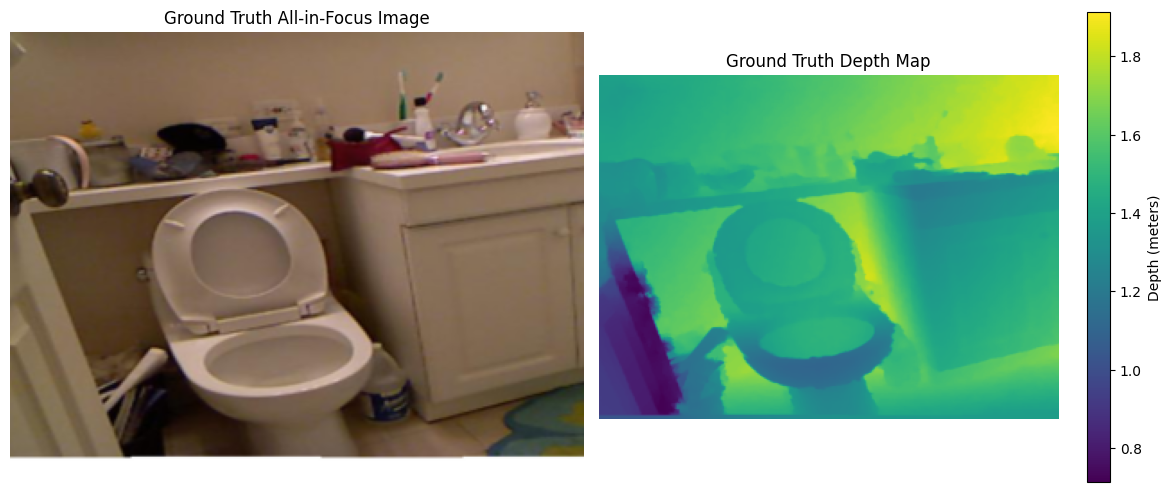

Image dimensions: 240 x 320
Adaptive kernel size: 11


In [3]:
# Initialize NYUv2 dataset configuration
dataset_params = DatasetParams.for_NYUv2()

# Load example image: ground truth AIF and depth map
gt_aif, gt_dpt = dataset_loader.load_example_image(res='half')

# Visualize ground truth AIF image
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(gt_aif / 255.)
plt.title('Ground Truth All-in-Focus Image')
plt.axis('off')

# Visualize ground truth depth map
plt.subplot(1, 2, 2)
plt.imshow(gt_dpt)
plt.title('Ground Truth Depth Map')
plt.colorbar(label='Depth (meters)')
plt.axis('off')
plt.tight_layout()
plt.show()

# Print image dimensions
width, height = gt_dpt.shape
print(f'Image dimensions: {width} x {height}')

# Set adaptive kernel size based on image dimensions
max_kernel_size = utils.kernel_size_heuristic(width, height)
print(f'Adaptive kernel size: {max_kernel_size}')

In [4]:
# Validate dataset parameters and config
print("=== Dataset Params (NYUv2) ===")
print(f"  f  (focal length):  {dataset_params.f}")
print(f"  D  (aperture dia):  {dataset_params.D}")
print(f"  Zf (focus dists):   {dataset_params.Zf}")
print(f"  ps (pixel size):    {dataset_params.ps}")
print(f"  min_Z:              {dataset_params.min_Z}")
print(f"  max_Z:              {dataset_params.max_Z}")
print(f"  thresh:             {dataset_params.thresh}")

print("\n=== Runtime Config ===")
print(f"  max_kernel_size:    {max_kernel_size}")
print(f"  gt_aif shape:       {gt_aif.shape}")
print(f"  gt_aif range:       [{gt_aif.min():.1f}, {gt_aif.max():.1f}]")
print(f"  gt_dpt shape:       {gt_dpt.shape}")
print(f"  gt_dpt range:       [{gt_dpt.min():.4f}, {gt_dpt.max():.4f}]")

=== Dataset Params (NYUv2) ===
  f  (focal length):  0.05
  D  (aperture dia):  0.00625
  Zf (focus dists):   [1.  1.5 2.5 4.  6. ]
  ps (pixel size):    1.2e-05
  min_Z:              0.1
  max_Z:              10.0
  thresh:             2

=== Runtime Config ===
  max_kernel_size:    11
  gt_aif shape:       (240, 320, 3)
  gt_aif range:       [0.0, 255.0]
  gt_dpt shape:       (240, 320)
  gt_dpt range:       [0.7140, 1.9124]


---

## Step 2: Generate Synthetic Defocus Stack

Use the forward model to generate a synthetic defocus stack from the ground truth depth and AIF image. This simulates capturing multiple images at different focus distances.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00733042..1.0363318].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009103269..1.0079689].


Defocus stack shape: (5, 240, 320, 3)
  - Number of focus levels: 5
  - Image dimensions: 240 x 320
  - Channels: 3


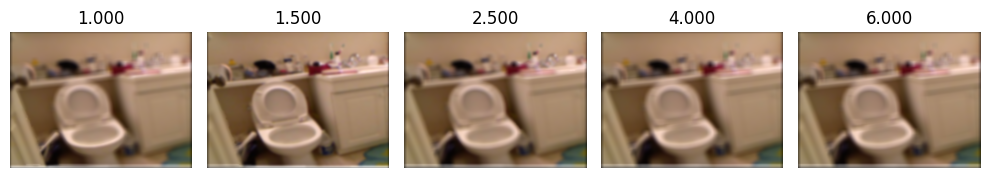

In [5]:
# Generate synthetically-blurred defocus stack
# This creates N images (N = fs = 5), each focused at a different depth
defocus_stack = forward_model.forward(gt_dpt, gt_aif, dataset_params, max_kernel_size)

print(f'Defocus stack shape: {defocus_stack.shape}')
print(f'  - Number of focus levels: {defocus_stack.shape[0]}')
print(f'  - Image dimensions: {defocus_stack.shape[1]} x {defocus_stack.shape[2]}')
print(f'  - Channels: {defocus_stack.shape[3]}')

# Visualize the defocus stack
# Each image is focused at a different depth
utils.plot_single_stack(defocus_stack / 255., dataset_params.Zf)

---

## Step 3: AIF Initialization

Compute an initial all-in-focus image using MRF optimization. This selects the sharpest pixel at each location while enforcing spatial smoothness using graph cuts (based on Suwajanakorn et al.).

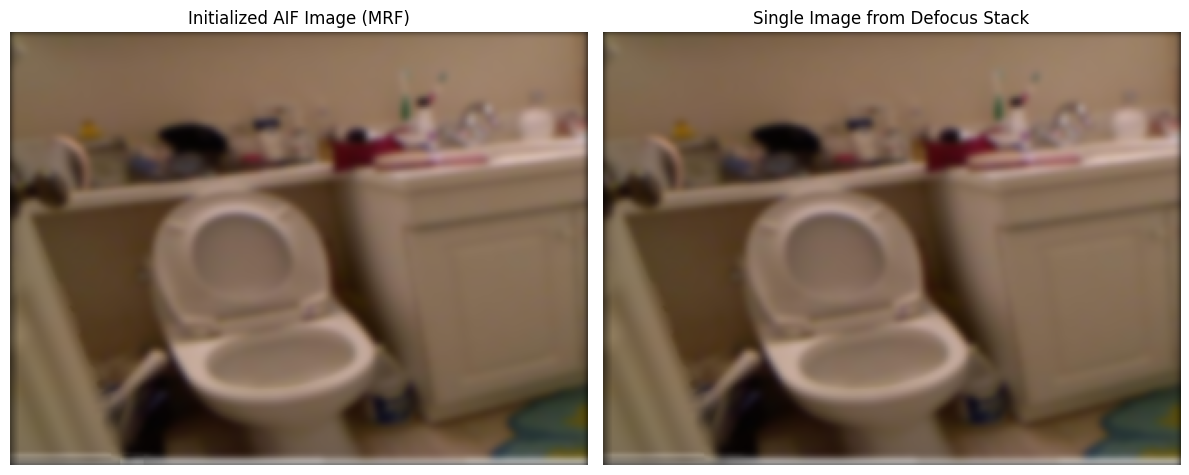

AIF initialization complete!


In [6]:
# Compute AIF initialization using MRF optimization
# - lmbda: controls tradeoff between two terms in optimization
# - sharpness_measure: method for computing sharpness ('sobel_grad', 'laplacian', 'log')
aif_init = initialization.compute_aif_initialization(
    defocus_stack, 
    lmbda=0.05, 
    sharpness_measure='sobel_grad'
)

# Visualize initialized AIF and compare to one image from the stack
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(aif_init / 255.)
plt.title('Initialized AIF Image (MRF)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(defocus_stack[1] / 255.)
plt.title('Single Image from Defocus Stack')
plt.axis('off')

plt.tight_layout()
plt.show()

print('AIF initialization complete!')

---

## Step 4: Alternating Minimization Optimization

Run the alternating minimization algorithm to jointly optimize the depth map and AIF image. The algorithm alternates between:
1. **Depth update**: Optimize depth given current AIF
2. **AIF update**: Optimize AIF given current depth

This example will take ~10 minutes to run.

### Required inputs:
- `dataset_params`: Camera and scene parameters (focal length, aperture, focus distances, pixel size, depth range, CoC threshold)
- `max_kernel_size`: Maximum blur kernel size, derived from image dimensions

### Optimization parameters:
- `num_epochs`: Number of full alternating minimization iterations
- `num_Z`: Number of depth candidates to evaluate per pixel during grid search
- `T_0`: Initial number of bounded FISTA iterations
- `alpha`: Multiplier for FISTA iterations
- `nesterov_first`: Whether to first optimize for depth or AIF

Starting alternating minimization optimization...

Depth range: [ 0.1 - 10.0 ]
Created experiment folder: /home/holly/Documents/depth-from-defocus/dfd/experiments/alt-min_2026-02-17_18-12-31
Images in range [0-255]


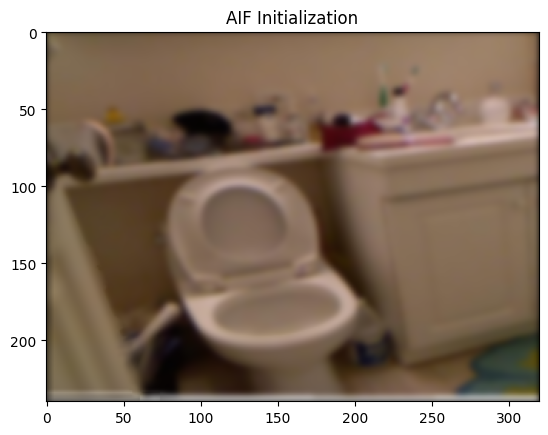

Iteration 0 



Grid search         : 100%|███████████████████| 100/100 [00:11<00:00,  8.41it/s]


GRID SEARCH DURATION 11.978591918945312


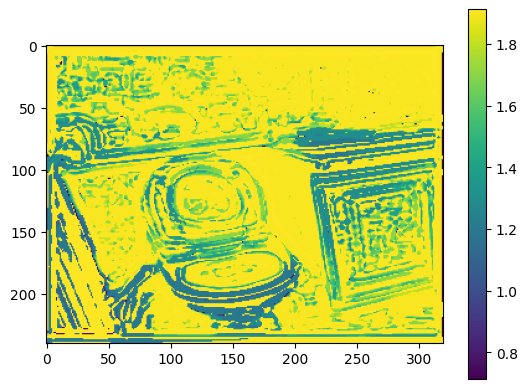


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 10.061691045761108


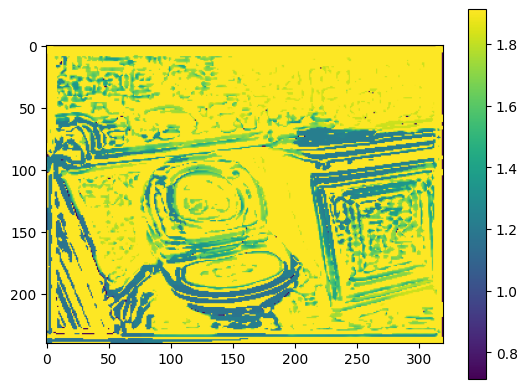

Loss: 22.301998 , TV: 32253.895

DPT result range: [ 0.104508504 , 9.995491 ]


Bounded FISTA...


Optimizing: 100%|██████████| 200/200 [01:01<00:00,  3.27it/s]


r1norm 2223.5315 norm(x) 51786.043
FISTA duration 63.17420959472656

AIF result range: [ 0.0 , 255.0 ]
Loss: 4.2917976 , TV: 4923227.0


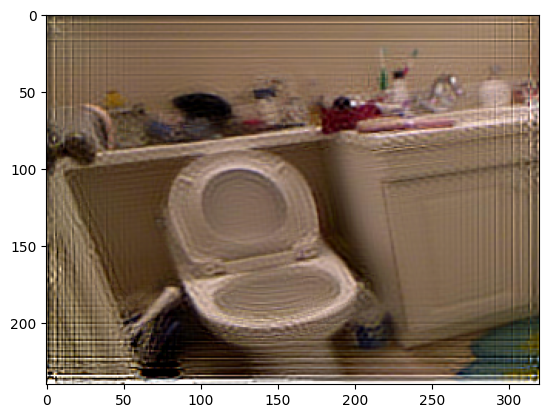

FULL ITER DURATION 87.00873804092407
T_i updated to 210


--------------------------

Iteration 1 



Grid search         : 100%|███████████████████| 100/100 [00:14<00:00,  6.99it/s]


GRID SEARCH DURATION 14.383522510528564


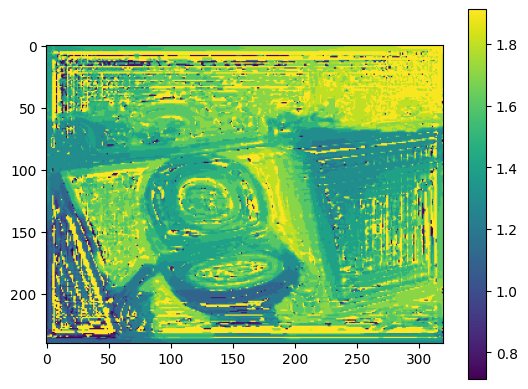


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 15.25309443473816


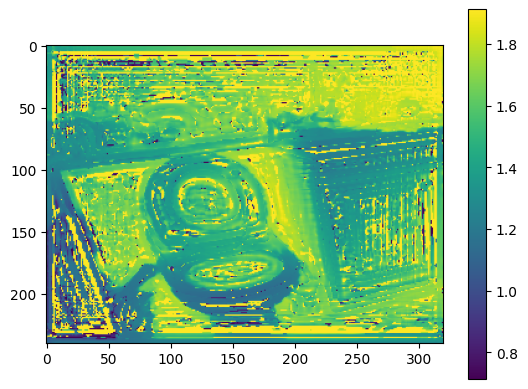

Loss: 1.5674124 , TV: 30960.256

DPT result range: [ 0.104508504 , 9.995491 ]


Bounded FISTA...


Optimizing: 100%|██████████| 210/210 [01:13<00:00,  2.86it/s]


r1norm 609.9757 norm(x) 51590.28
FISTA duration 76.3484435081482

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.32298094 , TV: 2710235.5


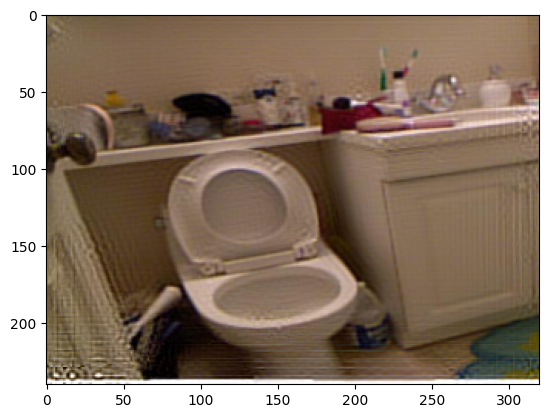

FULL ITER DURATION 108.15937447547913
T_i updated to 220


--------------------------

Iteration 2 



Grid search         : 100%|███████████████████| 100/100 [00:16<00:00,  6.04it/s]


GRID SEARCH DURATION 16.637566328048706


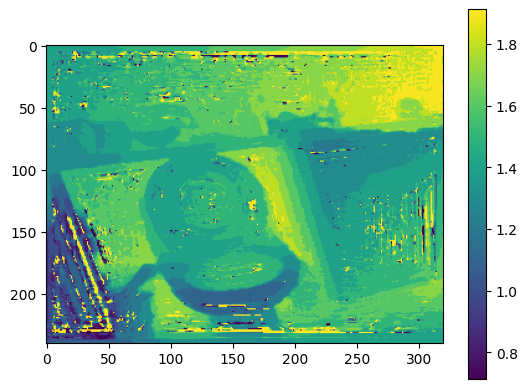


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 16.507144927978516


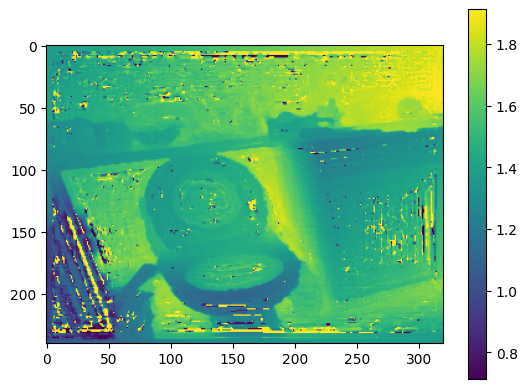

Loss: 0.103761785 , TV: 12334.308

DPT result range: [ 0.104508504 , 9.995491 ]


Bounded FISTA...


Optimizing: 100%|██████████| 220/220 [01:05<00:00,  3.33it/s]


r1norm 190.62692 norm(x) 51598.668
FISTA duration 69.08775663375854

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.031543773 , TV: 2219430.2


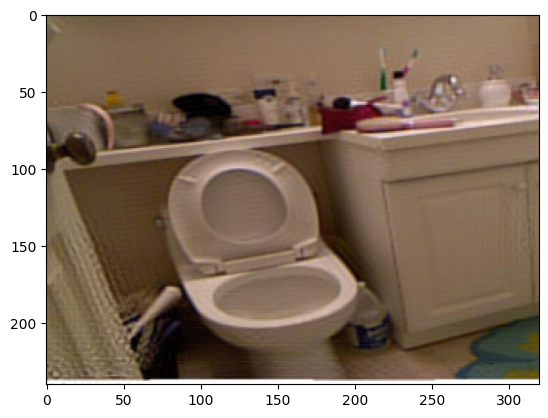

FULL ITER DURATION 104.28838181495667
T_i updated to 231


--------------------------

Iteration 3 



Grid search         : 100%|███████████████████| 100/100 [00:14<00:00,  6.97it/s]


GRID SEARCH DURATION 14.420332908630371


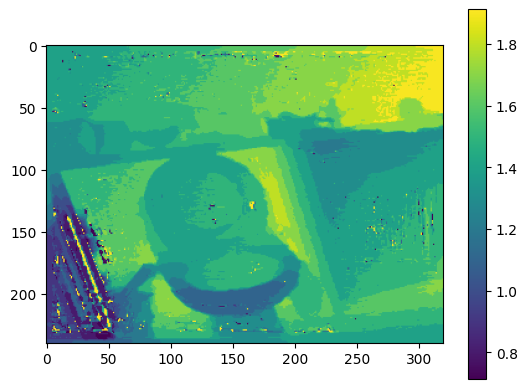


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 11.412995338439941


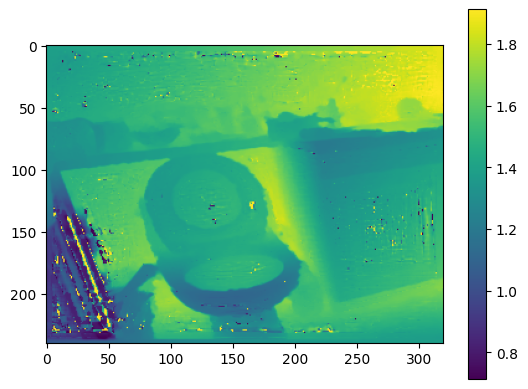

Loss: 0.015612271 , TV: 5047.328

DPT result range: [ 0.104508504 , 9.995491 ]


Bounded FISTA...


Optimizing: 100%|██████████| 231/231 [01:00<00:00,  3.81it/s]


r1norm 97.434425 norm(x) 51601.766
FISTA duration 62.733564615249634

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.008240572 , TV: 2087204.2


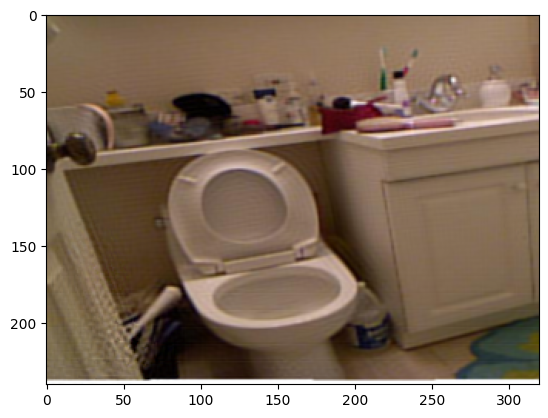

FULL ITER DURATION 90.23824381828308
T_i updated to 242


--------------------------

Iteration 4 



Grid search         : 100%|███████████████████| 100/100 [00:14<00:00,  7.07it/s]


GRID SEARCH DURATION 14.22041130065918


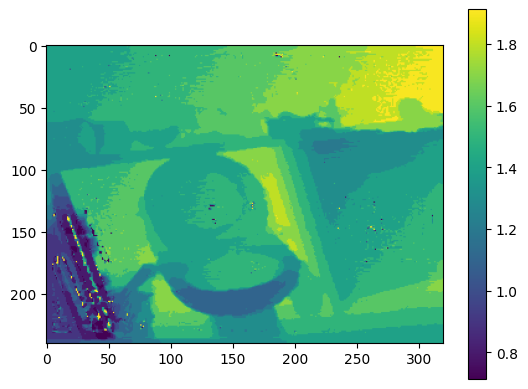


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 11.593566656112671


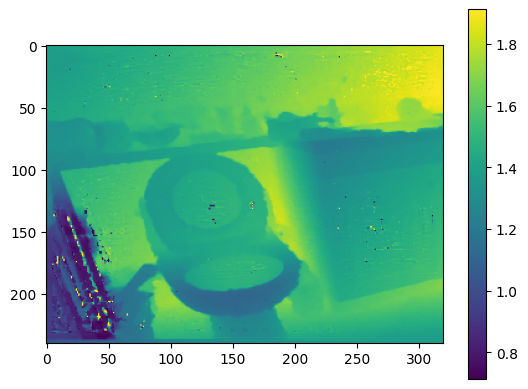

Loss: 0.005363923 , TV: 2759.3896

DPT result range: [ 0.104508504 , 9.995491 ]


Bounded FISTA...


Optimizing: 100%|██████████| 242/242 [01:03<00:00,  3.82it/s]


r1norm 63.76013 norm(x) 51603.32
FISTA duration 65.43996787071228

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0035286986 , TV: 2045478.2


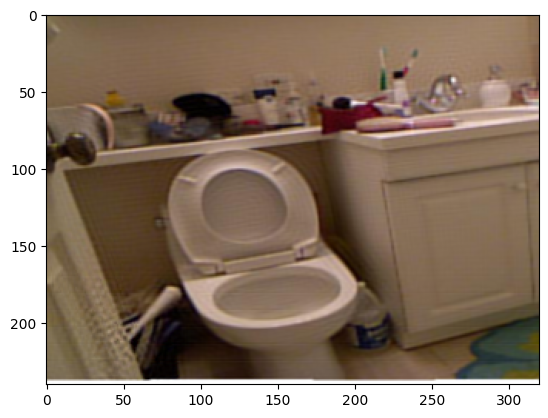

FULL ITER DURATION 92.9233717918396
T_i updated to 254


--------------------------


Optimization complete!


In [7]:
# Run alternating minimization optimization
print('Starting alternating minimization optimization...\n')

dpt, aif, _, _ = alternating_minimization.alternating_minimization(
    defocus_stack,
    # Camera/scene params (focal length, aperture, focus distances, depth range, etc.)
    dataset_params,
    # Max blur kernel size (controls forward model resolution)
    max_kernel_size,
    # Optimization parameters
    num_epochs=5,           # Number of complete alternating minimization iters
    num_Z=100,              # Number of depth candidates to eval during grid search
    T_0=200,                # Initial FISTA iterations
    alpha=1.05,             # Multiplier for FISTA iterations
    nesterov_first=False,   # First solve for depth, then AIF
    # Initialization
    aif_init=aif_init,      # Use MRF-initialized AIF
    # Visualization
    show_plots=True,        # Display plots during optimization
    save_plots=False,       # Don't save plots to disk
    vmin=gt_dpt.min(),      # Min depth for visualization only
    vmax=gt_dpt.max(),      # Max depth for visualization only
    verbose=True            # Print progress
)

print('\nOptimization complete!')

---

## Step 5: Evaluate Results

Compute accuracy metrics to compare the estimated depth with ground truth:
- **RMS**: Root mean squared error
- **Rel**: Relative absolute error
- **δ_n**: Percentage of pixels where max(pred/gt, gt/pred) < 1.25^n

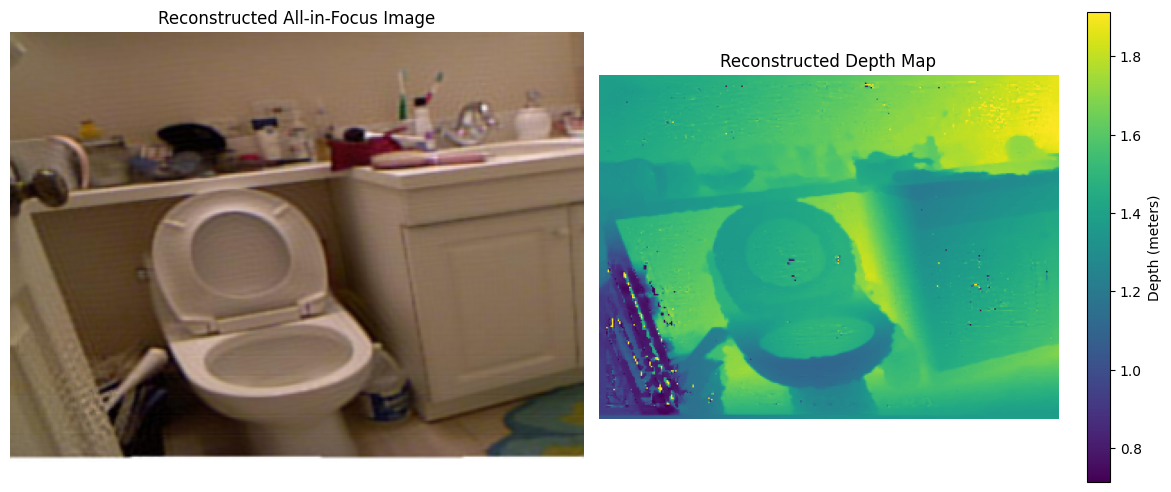

ACCURACY METRICS
RMS Error:           0.096646
Relative Error:      0.012999
δ < 1.25:            0.9884
δ < 1.25²:           0.9958
δ < 1.25³:           0.9975


In [8]:
# Visualize reconstructed AIF image
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(aif / 255.)
plt.title('Reconstructed All-in-Focus Image')
plt.axis('off')

# Visualize ground truth depth map
plt.subplot(1, 2, 2)
plt.imshow(dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.title('Reconstructed Depth Map')
plt.colorbar(label='Depth (meters)')
plt.axis('off')
plt.tight_layout()
plt.show()

# Compute accuracy metrics
rms = utils.compute_RMS(dpt, gt_dpt)
rel = utils.compute_AbsRel(dpt, gt_dpt)
accuracy_metrics = utils.compute_accuracy_metrics(dpt, gt_dpt)

# Display results
print('=' * 50)
print('ACCURACY METRICS')
print('=' * 50)
print(f'RMS Error:           {rms:.6f}')
print(f'Relative Error:      {rel:.6f}')
print(f'δ < 1.25:            {accuracy_metrics["delta1"]:.4f}')
print(f'δ < 1.25²:           {accuracy_metrics["delta2"]:.4f}')
print(f'δ < 1.25³:           {accuracy_metrics["delta3"]:.4f}')
print('=' * 50)

---

## Step 6: Outlier Removal (Optional)

Apply post-processing to remove outlier depth estimates. This identifies and removes unreliable depth estimates.

### Parameters:
- `tv_thresh`: TV threshold above which a pixel is flagged
- `patch_type`: Outlier detection strategy

Removing outliers...
found 4083 outliers


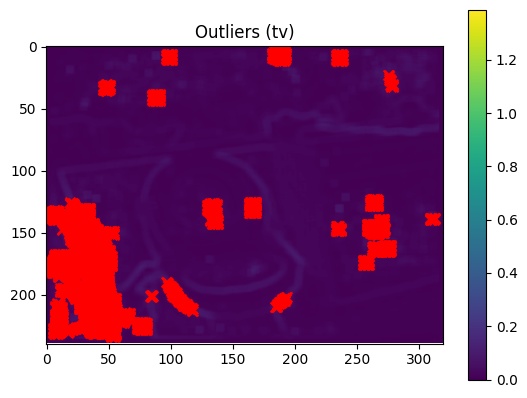

4083 / 4083 outliers removed
5.3164% of pixels flagged as outliers


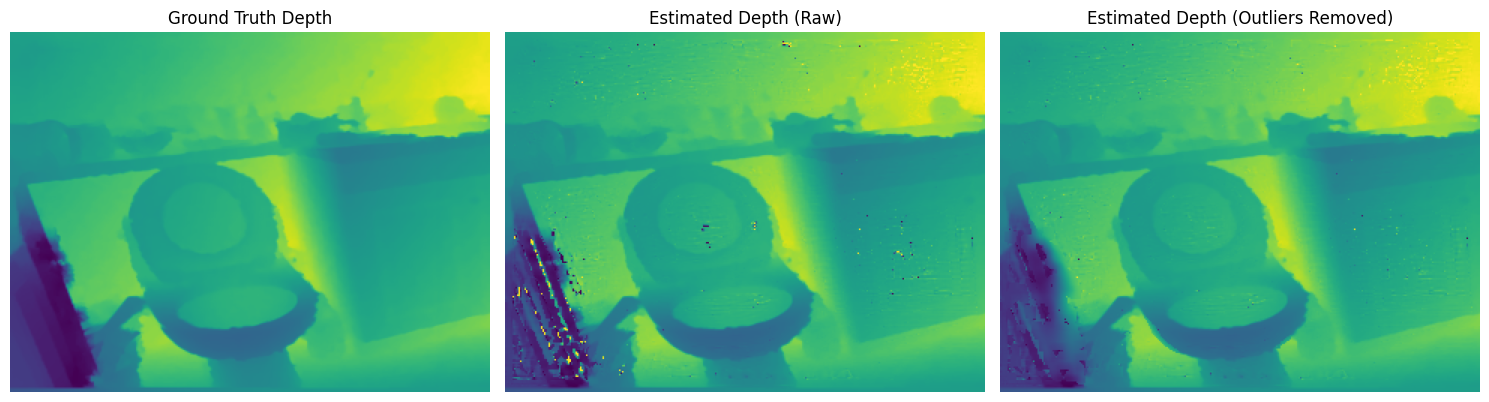

In [ ]:
# Remove outlier depth estimates
depth_no_outliers, outlier_fraction = outlier_removal.remove_outliers(
    dpt, 
    aif,
    neighborhood_size=max_kernel_size,
    tv_thresh=0.15,     # TV threshold above which a pixel is flagged
    patch_type='tv'     # Use total variation strategy to detect outliers
)

print(f'{(outlier_fraction*100):.4f}% of pixels flagged as outliers')

# Visualize cleaned depth map
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.title('Ground Truth Depth')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.title('Estimated Depth (Raw)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(depth_no_outliers, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.title('Estimated Depth (Outliers Removed)')
plt.axis('off')

plt.tight_layout()
plt.show()